# Southern Ocean

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import gsw
import copy

## Initialize Dataset

Read CMIP6 data from Google Cloud using intake

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

In [4]:
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def func_get_data(col, model, var, expe, freq, 
                  mem = 'r1i1p1f1', grid = 'gr', 
                  z_kwargs = {'consolidated': True, 'decode_times':True}):
    dcat = col.search(variable_id = var,
                      table_id = freq, 
                      experiment_id = expe,
                      source_id = model,
                      member_id = mem, 
                      grid_label = grid)
    if dcat.df.empty:
        print('No data')
    else:
        key0 = list(dcat.keys())[0]
        data_source = dcat[key0]
        dataset = data_source(zarr_kwargs=z_kwargs, preprocess=rename_coords).to_dask()
        dataset = dataset.squeeze('member_id')
        dataset = dataset.reset_coords('member_id', drop = True)
        return dataset

In [5]:
model_name = 'GFDL-CM4' 
# Potential Temperature, Sanility
variables = ['thetao', 'so'] 
experiment = 'piControl'
frequency = 'Omon'

datasets = {}
for var in variables:
    print(var)
    datasets[var] = func_get_data(col, model_name, var, experiment, frequency)

thetao
so


## Find Convection area and define convection index

### Select time period and month

In [6]:
def sel_time(ds, start_year, end_year, month = 0):
    ds = ds.isel(time = slice((start_year-1)*12, end_year*12))
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    return ds

### Calculate density
Function smow and dens0 are modified from [python-seawater](https://github.com/pyoceans/python-seawater/tree/master/seawater)

In [7]:
def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

### Regrid the data 

In [8]:
def func_regrid(ds, ds_out, reuse=False, clear=True):
    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, reuse_weights = reuse, ignore_degenerate=True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    if clear:
        dsr.clean_weight_file()
    return dsr_out

### Calculate mixed layer depth

In [9]:
def func_mld(dens_diff, depths):
    '''
    Calculating the mixed layer depth based on the constant potential density 
    difference criterion.
    MLD = depth where(sigma[mld] = sigma[10] + 0.03 kg/m3). 
    (0.03 kg/m3 ~= 0.03 psu)
    ----------
    Parameters
    dens_diff: Data array of density difference [density - density(at 10m) - 0.03]
    depths:    Data array of depth 
    ----------
    References
    .. [1] de Boyer Montégut, C., G. Madec, A. S. Fischer, A. Lazar, and 
    D. Iudicone, 2004: Mixed layer depth over the global ocean: an examination
    of profile data and a profile-based climatology. J. Geophys. Res., 109, 
    C12003. doi:10.1029/2004JC002378
    '''
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[:nind], depths[:nind])
    return mld

In [10]:
def xr_func_mld(dens):
    dens10 = dens.interp(lev=10, method='linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25,"lon":45,"lat":45}),  
        dens_diff.lev,
        input_core_dims=[["lev"], ["lev"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[dens_diff.lev.dtype])
    return mld

### Calculate convection index

In [11]:
#### Define region dict ####
region_dict = {
    'ws':{'name':'Weddell Sea', # Weddell Sea [60W-30E, 90S-50S]
          'lon':np.concatenate((np.arange(300.1,360.1), np.arange(0.1,31.1))),
          'lat':np.arange(-90,-49),
          'rlon':345, # representative lon lat
          'rlat':-70,
          'convdepth':2000,  # mld >= 2000 as conv area
          'convind':2000},  # conv index -- temp at 1500m 
    'rs':{'name':'Ross Sea', # Ross Sea [160W-130E, 90S-50S]
          'lon':np.arange(160.1, 231.1),
          'lat':np.arange(-90,-49),
          'rlon':195,
          'rlat':-70,
          'convdepth':2000,
          'convind':500},    
}   

In [12]:
def select_conv_area_data(ds, conv_area):
    ds = ds.copy()
    ds = ds.where(conv_area>=0)
    ds = ds.groupby('time.year').mean(dim='time', skipna=True)
    ds = ds.mean(dim='lon', skipna=True).mean(dim='lat', skipna=True)
    return ds

In [13]:
def select_region(ds, region, reg_dict = region_dict):
    return ds.sel(lon = reg_dict[region]['lon'], lat = reg_dict[region]['lat'], method="nearest")

In [14]:
def add_region_attrs(ds, region, reg_dict = region_dict):
    ds.attrs['region_name'] = reg_dict[region]['name']
    ds.attrs['conv_index'] = reg_dict[region]['convind']
    ds.attrs['rep_lon'] = reg_dict[region]['rlon']
    ds.attrs['rep_lat'] = reg_dict[region]['rlat']
    return ds

In [15]:
def func_conv_data(datasets, region, start_year, end_year, reg_dict = region_dict, month_no = 9, regrid = False):
    da_t = sel_time(datasets['thetao'].thetao, start_year, end_year)
    da_s = sel_time(datasets['so'].so, start_year, end_year)
    da_dens = sel_time(dens0(da_s, da_t), start_year, end_year, month = month_no)
    if not type(regrid) == bool:
        da_dens = func_regrid(da_dens, regrid)
        da_t = func_regrid(da_t, regrid)
        da_s = func_regrid(da_s, regrid)
    da_dens = select_region(da_dens, region, reg_dict = reg_dict)
    da_t = select_region(da_t, region, reg_dict = reg_dict)
    da_s = select_region(da_s, region, reg_dict = reg_dict)
    da_mld = xr_func_mld(da_dens)
    conv = xr.where(da_mld >= reg_dict[region]['convdepth'], da_mld, np.nan)
    conv_area = conv.mean(dim = 'time', skipna = True)
    da_t_conv = select_conv_area_data(da_t, conv_area)
    da_s_conv = select_conv_area_data(da_s, conv_area)
    conv_area = add_region_attrs(conv_area, region, reg_dict = reg_dict)
    da_t_conv = add_region_attrs(da_t_conv, region, reg_dict = reg_dict)
    da_s_conv = add_region_attrs(da_s_conv, region, reg_dict = reg_dict)
    ind_t = da_t_conv.interp(lev = da_t_conv.conv_index)
    conv_ind = (ind_t - ind_t.mean('year'))/ind_t.std('year') * -1
    return conv_area, da_t_conv, da_s_conv, conv_ind

In [16]:
##### Regridding output data grid ####
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                      'lon': (['lon'], np.arange(0, 360, 1.0))})

In [17]:
start_year = 1
end_year = 500

In [18]:
conv_area_ws, conv_t_ws, conv_s_ws, conv_ind_ws = func_conv_data(datasets, 'ws', start_year, end_year)
conv_area_rs, conv_t_rs, conv_s_rs, conv_ind_rs = func_conv_data(datasets, 'rs', start_year, end_year)

### Create and Connect to Dask Distributed Cluster

In [19]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

options.worker_cores = 4 #16 / 4
options.worker_memory = 8 #32 / 8  

cluster = gateway.new_cluster(options)
cluster.adapt()

client = cluster.get_client() 
cluster

In [21]:
options

In [130]:
gateway.list_clusters()

[ClusterReport<name=prod.42a91fbbf69f47dfbea9d81d3cb1d870, status=RUNNING>]

In [31]:
conv_area_ws = conv_area_ws.load()

In [20]:
conv_t_ws = conv_t_ws.load()

In [23]:
conv_s_ws = conv_s_ws.load()

In [22]:
conv_ind_ws = conv_ind_ws.load()

In [25]:
conv_area_rs = conv_area_rs.load()

In [27]:
conv_t_rs = conv_t_rs.load()

In [28]:
conv_s_rs = conv_s_rs.load()

In [22]:
conv_ind_rs = conv_ind_rs.load()

### Select Box region convection year and nonconvection year data

In [24]:
def select_conv_year(ds, conv_ind, month = 0):
    conv_year = conv_ind.where(conv_ind>0.5, drop = True).year.values
    nonconv_year = conv_ind.where(conv_ind<=0.5, drop = True).year.values
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    else:
        ds = ds.groupby('time.year').mean(dim='time', skipna=True)
        ds = ds.rename({'year':'time'})
    conv_i = conv_year - 151
    nonconv_i = nonconv_year - 151
    ds_conv = ds.isel(time = conv_i).mean('time', skipna=True).load()
    ds_nonconv = ds.isel(time = nonconv_i).mean('time', skipna=True).load()
    return ds_conv, ds_nonconv

In [25]:
region_box = {
    'ws':{'name':'Weddell Sea', 
          'lon':np.concatenate((np.arange(300.1,359.1), np.arange(0.1,30.1))),
          'lat':np.arange(-80,-40)},
    'rs':{'name':'Ross Sea', 
          'lon':np.arange(160.1, 230.1),
          'lat':np.arange(-80,-40)},
    'rsn':{'name':'Ross Sea (north)', 
           'lon':np.arange(160.1, 230.1),
           'lat':np.arange(-60,-40)},
    'rss':{'name':'Ross Sea (south)', 
           'lon':np.arange(160.1, 230.1),
           'lat':np.arange(-80,-60)},
    'rse':{'name':'Ross Sea (east)', 
          'lon':np.arange(195.1, 23.1),
          'lat':np.arange(-80,-40)},
    'rsw':{'name':'Ross Sea (west)', 
          'lon':np.arange(160.1, 194.1),
          'lat':np.arange(-80,-40)},
}

In [26]:
def func_conv_year_data(datasets, region, conv_ind, region_box, month_no=0):
    temp = select_region(datasets['thetao'].thetao, region, reg_dict = region_box)
    sanl = select_region(datasets['so'].so, region, reg_dict = region_box)
    if region == 'ws':
        temp = temp.assign_coords(lon = (((temp.lon + 180) % 360) - 180))
        sanl = sanl.assign_coords(lon = (((sanl.lon + 180) % 360) - 180))
    dens = dens0(sanl, temp)
    conv_t = select_conv_year(temp, conv_ind, month_no)
    conv_s = select_conv_year(sanl, conv_ind, month_no)
    conv_d = select_conv_year(dens, conv_ind, month_no)
    return conv_t, conv_s, conv_d

In [162]:
sep_ws = func_conv_year_data(datasets, 'ws', conv_ind_ws, region_box, month_no=9)
sep_rs = func_conv_year_data(datasets, 'rs', conv_ind_rs, region_box, month_no=9)

In [32]:
sep_rss = func_conv_year_data(datasets, 'rss', conv_ind_ws, region_box, month_no=9)
sep_rsn = func_conv_year_data(datasets, 'rsn', conv_ind_rs, region_box, month_no=9)

In [67]:
sep_rse = func_conv_year_data(datasets, 'rse', conv_ind_ws, region_box, month_no=9)
sep_rsw = func_conv_year_data(datasets, 'rsw', conv_ind_rs, region_box, month_no=9)

### Seawater properties calculations

In [39]:
def func_gsw_cal(t, s):
    # Calculates sea pressure from height assuming avg latitude
    p = gsw.p_from_z(-t.lev.values, t.rep_lat)
    #calculate absolute salinity from salinity, pressure, representative lon, lat 
    sa = gsw.SA_from_SP(s.values, p, s.rep_lon, s.rep_lat)
    #calculate conservative temp from absolute salinity and temp
    ct = gsw.CT_from_pt(sa, t.values)
    #calculate thermal expansion alpha with absolute salinity, conservative temp, pressure
    alpha = gsw.alpha(sa, ct, p)
    #calculate haline contraction beta with absolute salinity, conservative temp, pressure
    beta = gsw.beta(sa, ct, p)
    #calculate density with absolute salinity, conservative temp, pressure
    rho = gsw.rho(sa, ct, p)
    seawater = {
        'region_name':t.region_name,
        'lev':t.lev.values,
        'p':p,
        'sa':sa,
        'ct':ct,
        'alpha':alpha,
        'beta':beta,
        'rho':rho,
        'rho_constS':gsw.rho(np.mean(sa,0),ct,p),
        'rho_constT':gsw.rho(sa,np.mean(ct,0),p),
    }
    return seawater

In [40]:
seawater_ws = func_gsw_cal(conv_t_ws, conv_s_ws)

In [41]:
seawater_rs = func_gsw_cal(conv_t_rs, conv_s_rs)

## Visualize Data

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [43]:
sep_dens = sel_time(dens0(sel_time(datasets['so'].so, start_year, end_year), sel_time(datasets['thetao'].thetao, start_year, end_year)), 
                   start_year, end_year, month = 9)
sep_mld = xr_func_mld(sep_dens)
mld_sep_mean = sep_mld.mean('time').load()

Text(0.5, 1.0, 'Average September MLD - year 1-500, GFDL-CM4')

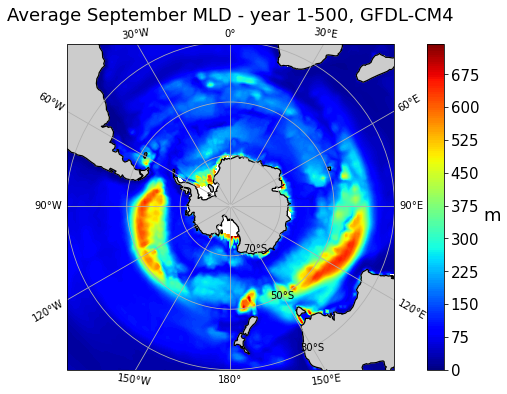

In [44]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=True)

plt_mld, plt_lon = add_cyclic_point(mld_sep_mean, coord=mld_sep_mean.lon)
my_level = np.arange(0,750,5)
im = ax.contourf(plt_lon, mld_sep_mean.lat, plt_mld, transform=ccrs.PlateCarree(), levels = my_level, cmap=plt.cm.jet)
cbar = plt.colorbar(im)
cbar.set_label('m', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Average September MLD - year '+ str(start_year) + '-' + str(end_year) + ', ' + model_name, fontsize=18)

In [45]:
pltmld_conv = conv_area_ws

Text(0.5, 1.0, 'Average September MLD (m) in Convection years \nWeddell Sea, year 1-500, GFDL-CM4')

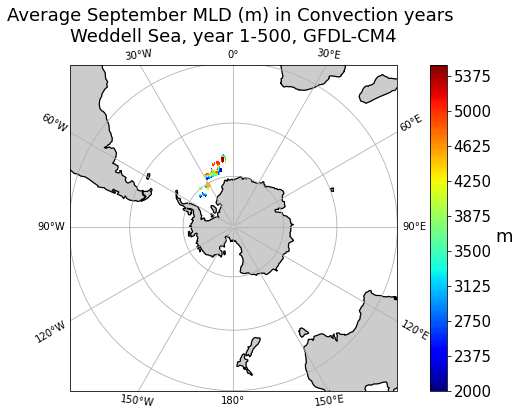

In [46]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=0, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=False)

im = ax.contourf(pltmld_conv.lon, pltmld_conv.lat, pltmld_conv, 
                 transform=ccrs.PlateCarree(), levels = 150, cmap=plt.cm.jet)
cbar = plt.colorbar(im)
cbar.set_label('m', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Average September MLD (m) in Convection years \n' + pltmld_conv.region_name + 
          ', year ' + str(start_year) + '-' + str(end_year) + ', ' + model_name, fontsize=18)

In [47]:
plt_temp = conv_t_ws

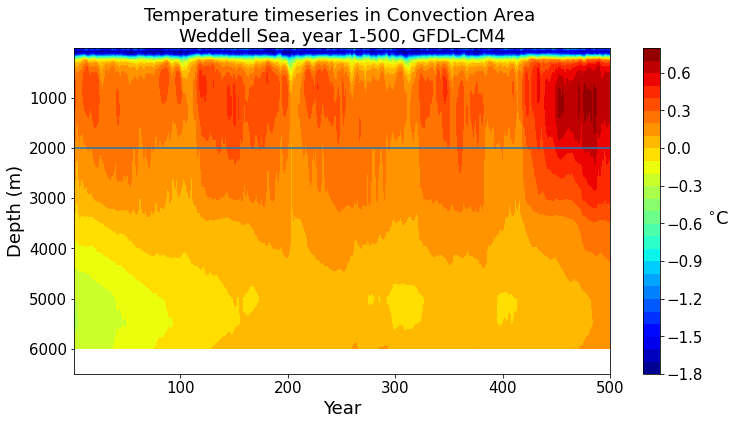

In [48]:
fig = plt.figure(figsize=(12,6))
im = plt.contourf(plt_temp.year-150, plt_temp.lev, plt_temp.transpose(), levels = 30, cmap=plt.cm.jet) 
plt.gca().invert_yaxis()
l = plt.axhline(y = plt_temp.conv_index)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Depth (m)', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Temperature timeseries in Convection Area \n'+ plt_temp.region_name
          + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('$^{\circ}$C', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
# fig.savefig('test2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

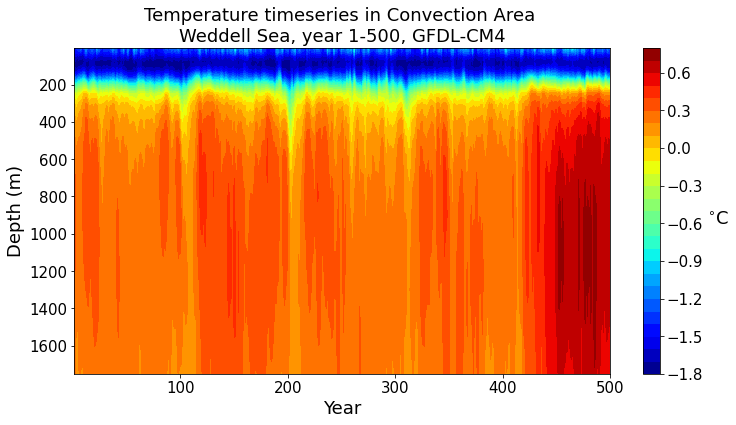

In [49]:
plt_temp_sf = plt_temp.sel(lev=slice(0,2000))

fig = plt.figure(figsize=(12,6))
im = plt.contourf(plt_temp_sf.year-150, plt_temp_sf.lev, plt_temp_sf.transpose(), levels = 30, cmap=plt.cm.jet) 
plt.gca().invert_yaxis()
plt.xlabel('Year', fontsize=18)
plt.ylabel('Depth (m)', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Temperature timeseries in Convection Area \n'+ plt_temp.region_name
          + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('$^{\circ}$C', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
# fig.savefig('test2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

Text(0.5, 1.0, 'Convection index timeseries (-1 * Temperature at 2000 m, normalized) \n Weddell Sea, year 1-500, GFDL-CM4')

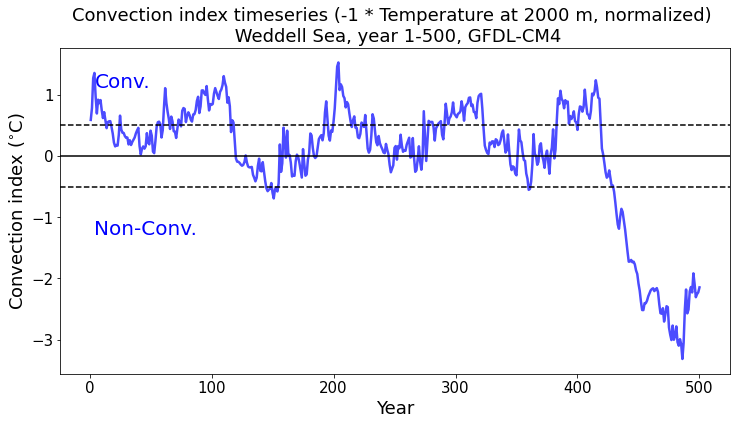

In [50]:
pltind = conv_ind_ws 

fig = plt.figure(figsize=(12,6))

plt.plot(pltind.year-150, pltind, 'b', linewidth = 2.5, alpha=0.7)
l = plt.axhline(y=-0.5, color='k', linestyle ='--')
l = plt.axhline(y=0, color='k')
l = plt.axhline(y=0.5, color='k', linestyle ='--')

plt.text(4, 1.2, 'Conv.', horizontalalignment='left', verticalalignment='center', fontsize=20, color='b')
plt.text(4, -1.2, 'Non-Conv.', horizontalalignment='left', verticalalignment='center', fontsize=20, color='b')

plt.ylabel('Convection index ($^{\circ}$C)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Convection index timeseries (-1 * Temperature at '+str(plt_temp.conv_index)+' m, normalized) \n '
          + plt_temp.region_name + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)

In [51]:
plt_san = conv_s_ws

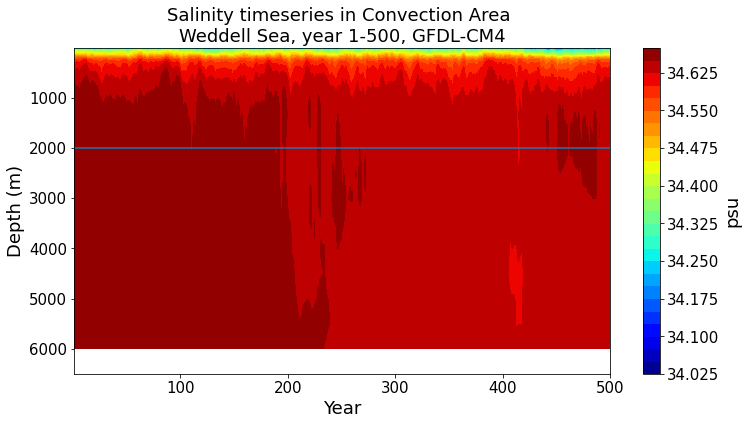

In [52]:
fig = plt.figure(figsize=(12,6))
im = plt.contourf(plt_san.year-150, plt_san.lev, plt_san.transpose(), levels = 30, cmap=plt.cm.jet) 
plt.gca().invert_yaxis()
l = plt.axhline(y = plt_san.conv_index)

plt.xlabel('Year', fontsize=18)
plt.ylabel('Depth (m)', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Salinity timeseries in Convection Area \n'+ plt_temp.region_name 
          + ', year ' + str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('psu', fontsize=18)
cbar.ax.tick_params(labelsize=15) 

In [53]:
plt_sw = seawater_ws

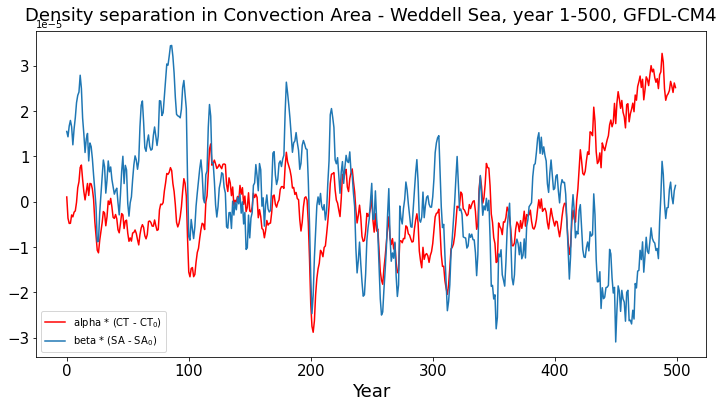

In [54]:
fig = plt.subplots(figsize=(12,6))
plt.plot(plt_sw['alpha'][:,13]*(plt_sw['ct'][:,13]-np.mean(plt_sw['ct'][:,13])),'r')
# plt.ylabel('alpha * (CT - CT_0), beta * (SA - SA_0)',fontsize = 18)
plt.plot(plt_sw['beta'][:,13]*(plt_sw['sa'][:,13]-np.mean(plt_sw['sa'][:,13])))
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Density separation in Convection Area - '+ plt_sw['region_name'] + ', year ' + 
             str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18, verticalalignment='bottom')
plt.legend(['alpha * (CT - CT$_0$)','beta * (SA - SA$_0$)'],loc ='lower left')

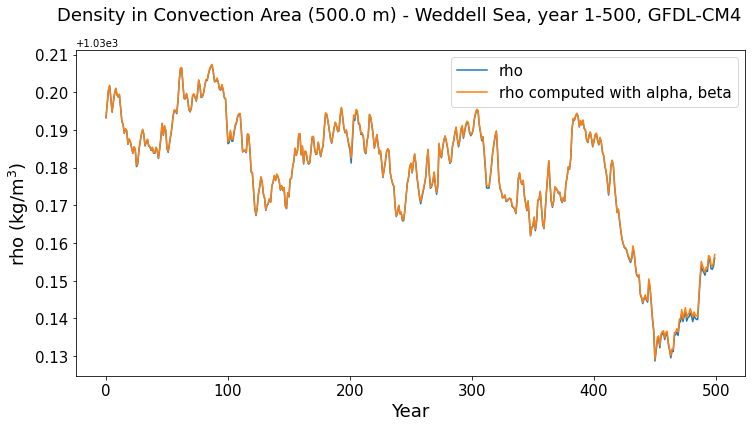

In [55]:
fig = plt.subplots(figsize=(12,6))

s_term_500 = plt_sw['beta'][:,13]*(plt_sw['sa'][:,13]-np.mean(plt_sw['sa'][:,13]))
t_term_500 = plt_sw['alpha'][:,13]*(plt_sw['ct'][:,13]-np.mean(plt_sw['ct'][:,13]))

s_term_0 = plt_sw['beta'][:,0]*(plt_sw['sa'][:,0]-np.mean(plt_sw['sa'][:,0]))
t_term_0 = plt_sw['alpha'][:,0]*(plt_sw['ct'][:,0]-np.mean(plt_sw['ct'][:,0]))

plt.plot((1 + s_term_500-t_term_500 + plt_sw['p'][13]/10.1325/1000/1500**2)*np.mean(plt_sw['rho'][:,13]))
plt.plot(plt_sw['rho'][:,13])
plt.ylabel('rho (kg/m$^3$)',fontsize=18)
plt.suptitle('Density in Convection Area (' + str(plt_sw['lev'][13])+ ' m) - '+ plt_sw['region_name'] + ', year ' + 
             str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18)
plt.xlabel('Year',fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(['rho','rho computed with alpha, beta'], fontsize = 15)

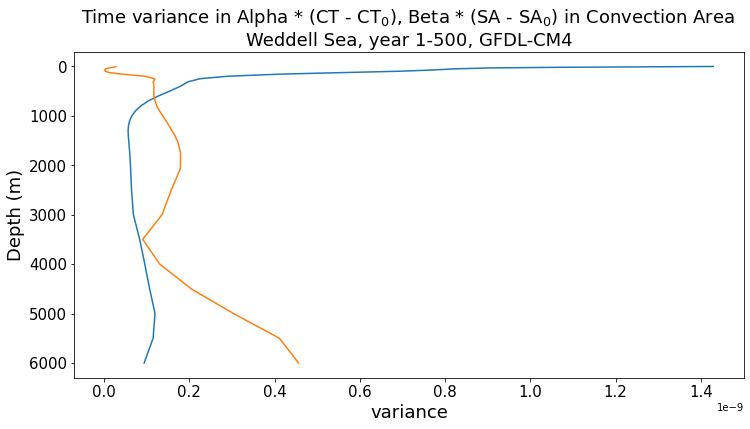

In [57]:
fig = plt.subplots(figsize=(12,6))
plt.plot(np.var(plt_sw['beta']*(plt_sw['sa']-np.mean(plt_sw['sa'],0)),0), plt_sw['lev'])
plt.plot(np.var(plt_sw['alpha']*(plt_sw['ct']-np.mean(plt_sw['ct'],0)),0), plt_sw['lev'])
plt.xlabel('variance', fontsize=18)
plt.ylabel('Depth (m)', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Time variance in Alpha * (CT - CT$_0$), Beta * (SA - SA$_0$) in Convection Area \n'
          + plt_sw['region_name']+', year '+ str(start_year)+'-'+str(end_year)+', '+model_name, fontsize=18) 
plt.gca().invert_yaxis()

In [58]:
def func_rho_timeplot(seawater, lev, start_year = start_year, end_year = end_year, model_name = model_name):
    plt.plot(seawater['rho_constS'][:,lev]-1000,'r')
    plt.plot(seawater['rho_constT'][:,lev]-1000,'b')
    plt.plot(seawater['rho'][:,lev]-1000,'g')
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('[rho - 1000] (kg/m$^3$)', fontsize=18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(['Rho (mean SA, variable CT)','Rho (variable SA, mean CT)','Rho (SA,CT)'], fontsize = 15)
    plt.title('rho calculated with constant SA, CT in Convection Area ({} m) \n {}, year {} - {}, {}'.format(
        seawater['lev'][lev], seawater['region_name'], start_year, end_year, model_name), fontsize=18)

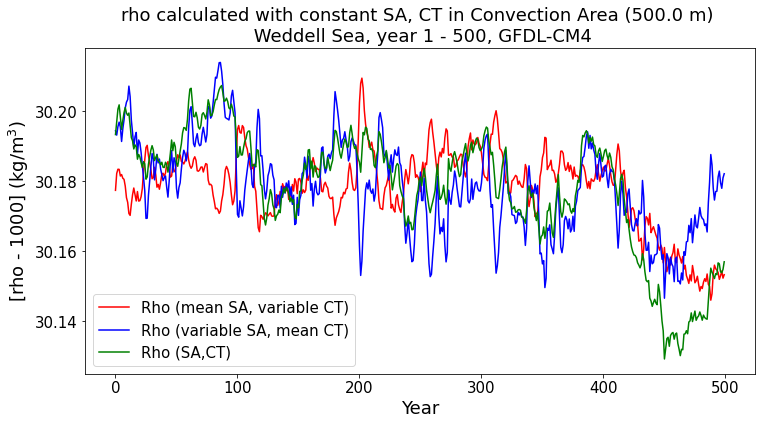

In [59]:
fig = plt.figure(figsize=(12,6))
func_rho_timeplot(plt_sw, 13)

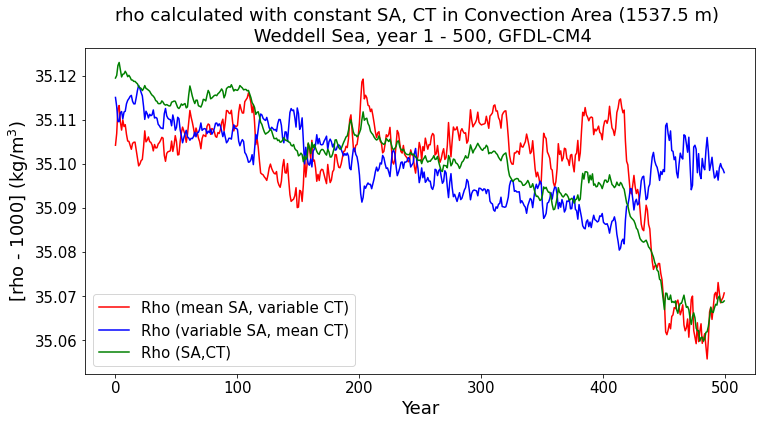

In [60]:
fig = plt.figure(figsize=(12,6))
func_rho_timeplot(plt_sw, 23)

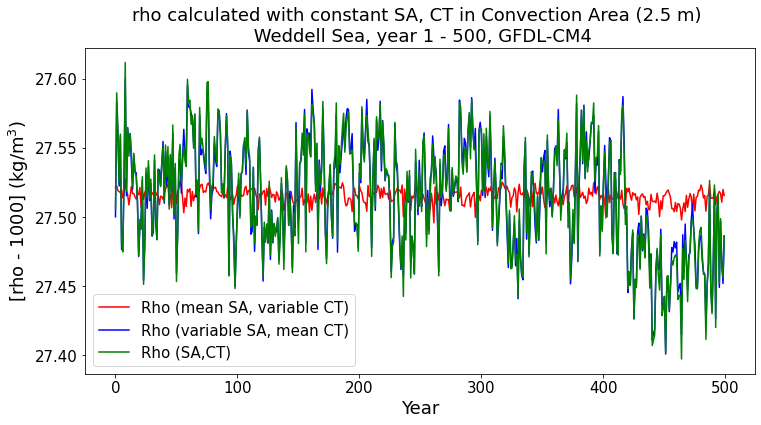

In [61]:
fig = plt.figure(figsize=(12,6))
func_rho_timeplot(plt_sw, 0)

Text(0, 0.5, 'Depth (m)')

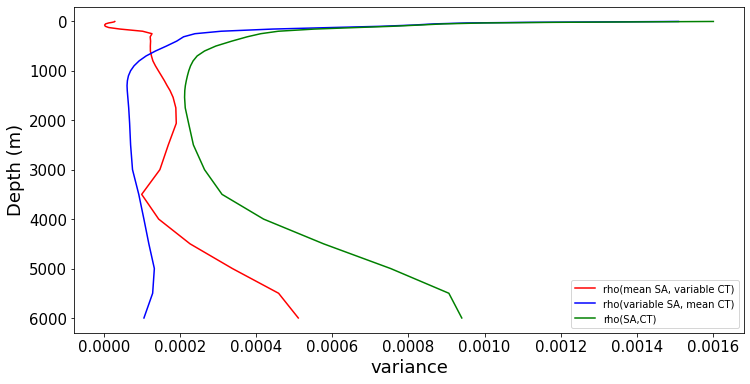

In [62]:
fig = plt.figure(figsize=(12,6))
plt.plot(np.var(plt_sw['rho_constS'],0), plt_sw['lev'],'r')
plt.plot(np.var(plt_sw['rho_constT'],0), plt_sw['lev'],'b')
plt.plot(np.var(plt_sw['rho'],0), plt_sw['lev'],'g')
plt.legend(['rho(mean SA, variable CT)','rho(variable SA, mean CT)','rho(SA,CT)'])
plt.gca().invert_yaxis()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('variance', fontsize=18)
plt.ylabel('Depth (m)', fontsize=18)

In [34]:
def func_plot_contour(ax, data1, data2, lev, coord2):
    plt.rcParams['contour.negative_linestyle'] = 'dashed'
    pd1 = data1.isel(lev = slice(lev[0], lev[1]))
    pd2 = data2.isel(lev = slice(lev[0], lev[1]))
    d_max = np.max([np.nanmax(pd1.values), np.nanmax(pd2.values)])
    d_min = np.min([np.nanmin(pd1.values), np.nanmin(pd2.values)])
    plot1 = ax.contour(pd1[coord2], pd1.lev, pd1, colors = 'red', levels = np.linspace(d_min, d_max,10))
    plot2 = ax.contour(pd2[coord2], pd2.lev, pd2, colors = 'blue', levels = np.linspace(d_min, d_max,10))
    ax.clabel(plot1)
    ax.clabel(plot2)
    ax.tick_params(labelsize=15)
    ax.invert_yaxis()

In [35]:
def func_plot_contour_diff(ax, data1, data2, lev, coord2):
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    pd1 = data1.isel(lev = slice(lev[0], lev[1]))
    pd2 = data2.isel(lev = slice(lev[0], lev[1]))
    diff = pd1 - pd2
    diff_n = diff.where(diff<0,  np.nan)
    diff_p = diff.where(diff>=0, np.nan)
    d_max = np.nanmax(diff_p.values)
    if not d_max >= 0:
        d_max = np.nanmax(diff_n.values)
    d_min = np.nanmin(diff_n.values)
    if not d_min < 0:
        d_min = np.nanmin(diff_p.values)
    plot1 = ax.contour(diff_p[coord2], diff_p.lev, diff_p, colors = 'red', levels = np.linspace(d_min, d_max,10))
    plot2 = ax.contour(diff_n[coord2], diff_n.lev, diff_n, colors = 'blue', levels = np.linspace(d_min, d_max,10))
    ax.clabel(plot1)
    ax.clabel(plot2)
    ax.tick_params(labelsize=15)
    ax.invert_yaxis()

In [36]:
def func_plot_conv_contour(ds, coord, slon=False, slat=False, diff = False):
    ds_conv = ds[0]
    ds_nconv = ds[1]
    if not type(slon) == bool:
        ds_conv = ds_conv.sel(lon = slon, method = 'nearest')
        ds_nconv = ds_nconv.sel(lon = slon, method = 'nearest')
        p_coord = 'lon = {:.1f}'.format(slon)
    elif not type(slat) == bool:
        ds_conv = ds_conv.sel(lat = slat, method = 'nearest')
        ds_nconv = ds_nconv.sel(lat = slat, method = 'nearest')
        p_coord = 'lat = {:.1f}'.format(slat)
    else:
        p_coord = '{} = avg({:.1f}:{:.1f})'.format(coord, ds_conv[coord].values[0], ds_conv[coord].values[-1])
        ds_conv = ds_conv.mean(dim = coord, skipna = True)
        ds_nconv = ds_nconv.mean(dim = coord, skipna = True)
    if coord == 'lon':
        coord2 = 'lat'
    elif coord == 'lat':
        coord2 = 'lon'
    fig, axs = plt.subplots(3, 1, figsize = (10, 10), sharex=True)
    if diff:
        func_plot_contour_diff(axs[0], ds_conv, ds_nconv, [0, 14], coord2)
        func_plot_contour_diff(axs[1], ds_conv, ds_nconv, [13, 19], coord2)
        func_plot_contour_diff(axs[2], ds_conv, ds_nconv, [18, None], coord2)
    else:
        func_plot_contour(axs[0], ds_conv, ds_nconv, [0, 14], coord2)
        func_plot_contour(axs[1], ds_conv, ds_nconv, [13, 19], coord2)
        func_plot_contour(axs[2], ds_conv, ds_nconv, [18, None], coord2)
    axs[1].set_ylabel('Depth /m', fontsize=18)
    if ds_conv.name == 'thetao':
        p_name = 'Temperature'
    elif ds_conv.name == 'so':
        p_name = 'Salinity'
    else:
        p_name = 'Density'
    if diff:
        plt.suptitle('{} difference contours - {}, year {}-{}, {}'.format(
            p_name, p_coord, start_year, end_year, model_name), 
                     fontsize=18)
    else:
        plt.suptitle('{} contours - {}, year {}-{}, {}'.format(
            p_name, p_coord, start_year, end_year, model_name), 
                     fontsize=18)
    plt.xlabel(coord2, fontsize=18)
    plt.tight_layout()

In [96]:
def func_plot_regionbox(da):
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND, zorder=0, color='0.8')
    ax.add_feature(cfeature.COASTLINE, linewidth=1.25)
    
    gl = ax.gridlines(
        xlocs = np.arange(-180,180,30), 
        ylocs = np.arange(-90,90,20),
        draw_labels=True, y_inline=True)
    
    ax.plot([da.lon.values[0], da.lon.values[0], da.lon.values[-1], da.lon.values[-1], da.lon.values[0]],
            [da.lat.values[0], da.lat.values[-1], da.lat.values[-1], da.lat.values[0], da.lat.values[0]], 
            'r', transform=ccrs.PlateCarree())
    ax.fill([da.lon.values[0], da.lon.values[0], da.lon.values[-1], da.lon.values[-1], da.lon.values[0]],
            [da.lat.values[0], da.lat.values[-1], da.lat.values[-1], da.lat.values[0], da.lat.values[0]], 
            color='coral', transform=ccrs.PlateCarree(), alpha=0.4)
# plt.title('Average September MLD (m) in Convection years \n' + pltmld_conv.region_name + 
#           ', year ' + str(start_year) + '-' + str(end_year) + ', ' + model_name, fontsize=18)

In [168]:
box_t, box_s, box_d = sep_ws

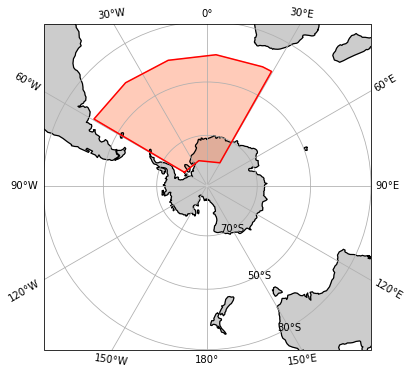

In [169]:
fig = plt.figure(figsize=(6, 6))
func_plot_regionbox(box_t[0])

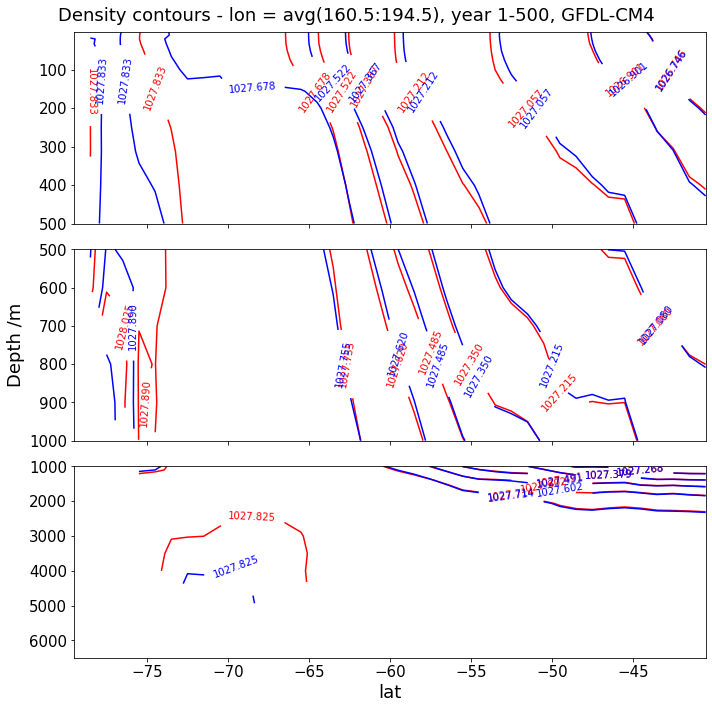

In [124]:
func_plot_conv_contour(box_d, 'lon')

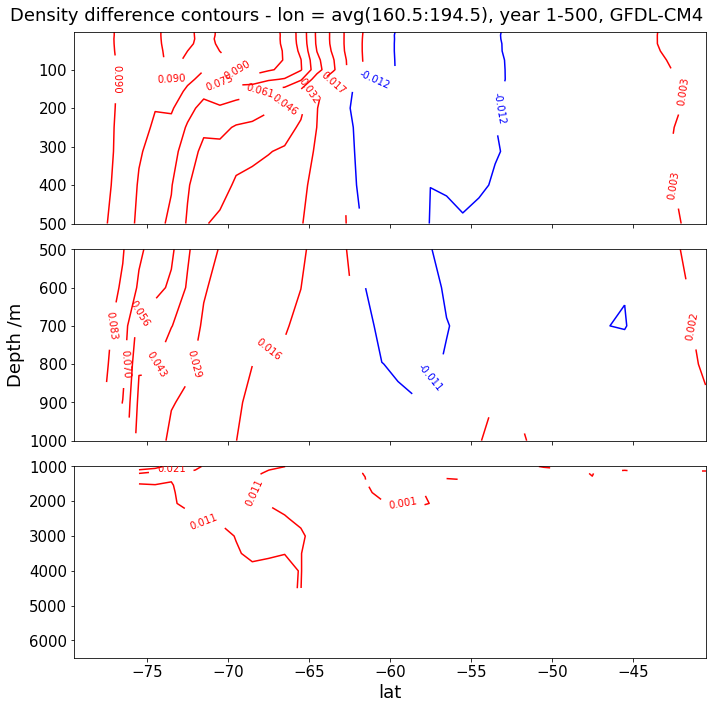

In [125]:
func_plot_conv_contour(box_d, 'lon', diff = True)

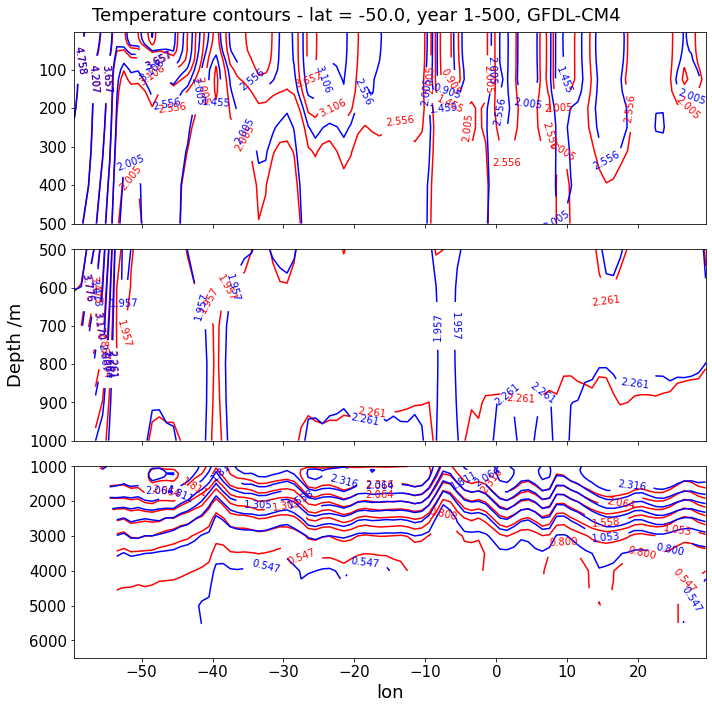

In [190]:
func_plot_conv_contour(box_t, 'lat', slat = -50)

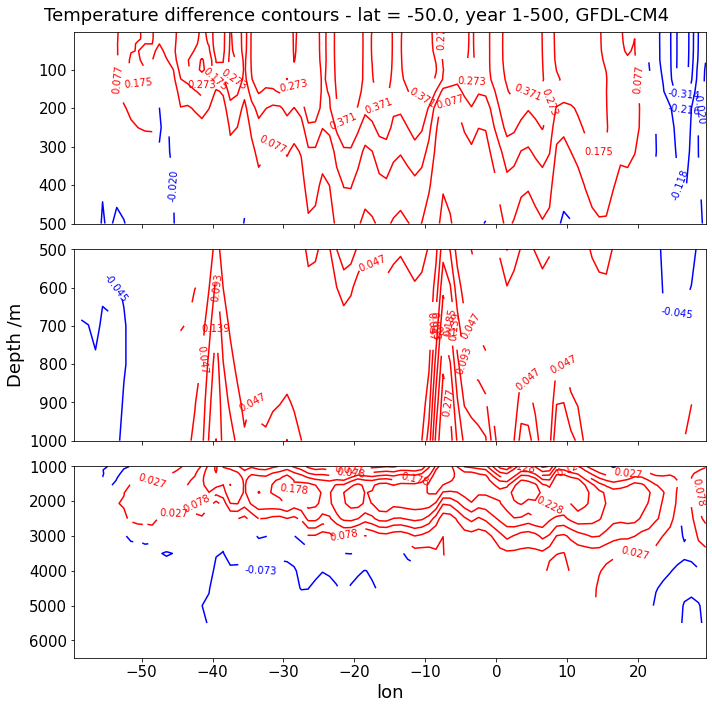

In [191]:
func_plot_conv_contour(box_t, 'lat', slat = -50, diff = True)

In [73]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

Text(0.5, 1.0, 'Lagged correlation (Ross Sea Convection index), year 1-500, GFDL-CM4')

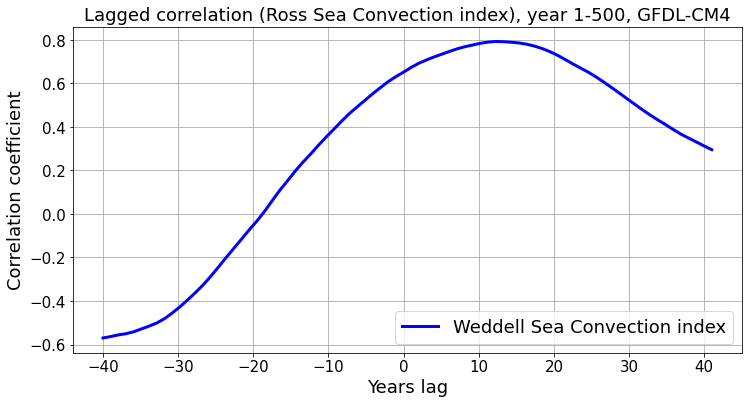

In [74]:
lag_time = 40

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_rs[:-9], conv_ind_ws[:-9],lag_time,'b','Weddell Sea Convection index')

''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18)
plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

In [24]:
import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

from geoviews import opts
gv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [25]:
def cal_slope(y, x):
    from scipy import stats
    mask = ~np.isnan(y)
    if len(x[mask])>0:
        slope, __, __, __, __ = stats.linregress(x[mask], y[mask])
    else:
        slope = np.nan
    return slope

def xr_lagcor_slope(ds, ds_ind, lag_year, lag):
    ds_ind = ds_ind.isel(year = slice(lag_year, -lag_year))
    if lag == 2*lag_year:   
        ds = ds.isel(time = slice(lag, None))
    else:      
        ds = ds.isel(time = slice(lag, -2*lag_year+lag))
    slope = xr.apply_ufunc(
        cal_slope, 
        ds.chunk({"time":-1,"lon":30}),  
        ds_ind,
        input_core_dims=[["time"], ["year"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[ds_ind.dtype])
    return slope

In [26]:
def func_lagcor(ds, ds_ind, lag_year):
    ds = (ds - ds.mean(dim = 'time', skipna = True))/ds.std(dim = 'time', skipna = True)
    ds_ind = (ds_ind - ds_ind.mean(dim = 'year', skipna = True))/ds_ind.std(dim = 'year', skipna = True)
    list_lag = []
    for lag in range(lag_year*2+1):
        ds_slope = xr_lagcor_slope(ds, ds_ind, lag_year, lag)
        ds_slope.coords['lag_year'] = lag-lag_year
        list_lag.append(ds_slope)
    ds_lag = xr.concat(list_lag, dim = 'lag_year')
    ds_new = ds_lag.rename('slope')
    ds_new.attrs['Property'] = ds_lag.name
    return ds_new

In [ ]:
gv.extension('bokeh')
qmesh = gv.Dataset(slope_ts_rs).to(gv.QuadMesh, ['lon', 'lat'], dynamic = True)
qmesh.opts(aspect = 'square', frame_width=400, colorbar=True, cmap='RdBu_r', projection=ccrs.SouthPolarStereo()) * gf.coastline

In [27]:
def func_lagcor_map(var, slev, ds_ind):
    ds = list(datasets[var][var].sel(lev = slev, method = 'nearest').groupby('time.month'))[8][-1]
    ds = ds.sel(lat = slice(-90,-30))
    ds_slope = func_lagcor(ds, ds_ind, 50)
    ds_slope = ds_slope.load()
    dsplot = gv.Dataset(ds_slope).to(gv.QuadMesh, ['lon', 'lat'], dynamic=False).opts(
        aspect = 'square', fig_size=200, xaxis=None, yaxis=None, colorbar=True, clim = (-1, 1), 
        cmap='RdBu_r', projection=ccrs.SouthPolarStereo()) * gf.coastline
    gv.save(dsplot, 'Images/map_{}_{:.0f}m.gif'.format(var, ds.lev.values), fmt='gif', fps=4)

In [28]:
for var in ['so']: #, 'thetao']:
    for slev in [500,2000,3000,4000]:
        func_lagcor_map(var, slev, conv_ind_rs)

In [53]:
def func_lagcor_transect(var, slat, ds_ind):
    ds = list(datasets[var][var].sel(lat = slat, method = 'nearest').groupby('time.month'))[8][-1]
    ds_slope = func_lagcor(ds, ds_ind, 50)
    ds_slope = ds_slope.load()
    dsplot = hv.Dataset(ds_slope).to(hv.QuadMesh, ['lon', 'lev']).opts(
        aspect=2, colorbar = True, clim = (-1,1), invert_yaxis=True, fig_size=200, cmap='RdBu_r')
    hv.save(dsplot, 'Images/transect_{}_{}.gif'.format(var, ds.lat.values), fmt='gif', fps=4)

In [54]:
for var in ['so', 'thetao']:
    for slat in [-70, -60, -50, -45]:
        func_lagcor_transect(var, slat, conv_ind_rs)

In [29]:
client.close()
cluster.close()